# Series de Tiempo Multivariada con RNN
---
----
# POR FAVOR LEA LO SIGUIENTE ANTES DE SEGUIR CON ESTE NOTEBOOK!

## NOTA: En general, es muy difícil obtener un buen rendimiento de un modelo RNN, basado en LSTM, para series de tiempo multivariadas.  Se recomienda fuertemente utilizar modelos basados en SARIMAX si es que se tiene una situación del mundo real que requiera datos de series de tiempo multivariadas. 

---
---

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# IGNORAR EL CONTENIDO DE ESTA CELDA
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

# Sobre los datos

Appliance Energy Usage: A Multivariate Time Series Forecasting Example

Experimental data used to create regression models of appliances energy use in a low energy building.
Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).
Original source of the dataset:
http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

Lectura de los datos

In [5]:
df = pd.read_csv('energydata_complete.csv',
                 index_col = 'date',
                 infer_datetime_format = True,
                 engine = "python")

In [6]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

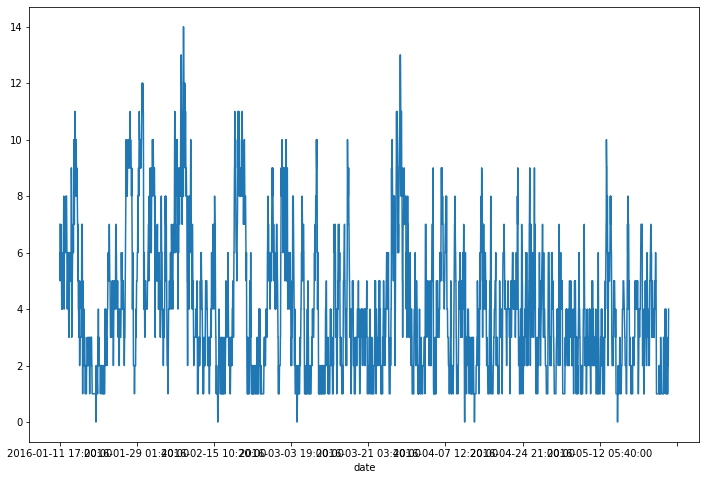

In [8]:
df['Windspeed'].plot(figsize = (12, 8))

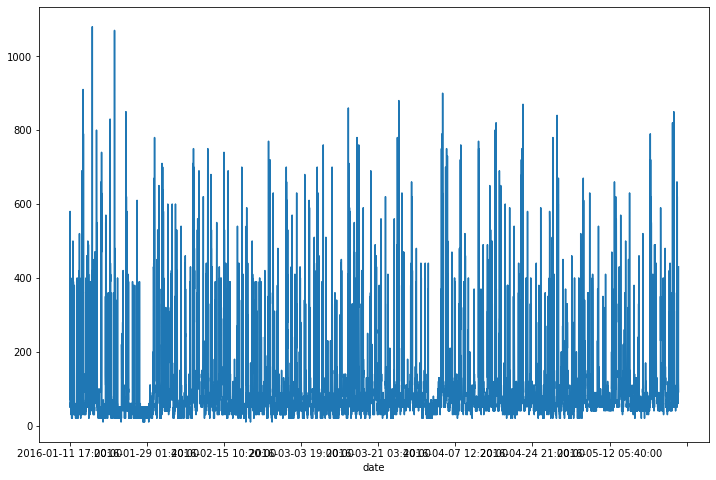

In [9]:
df['Appliances'].plot(figsize = (12, 8))

## División entreno - prueba

In [10]:
len(df)

19735

In [11]:
df.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.2,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [12]:
df.tail(5)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


Se desea pronosticar solo 24 horas hacia el futuro, no se necesitan 3 meses de datos para eso, así que para ahorrar algo de tiempo en el entrenamiento, se seleccionará solo los datos del último mes.

In [13]:
df.loc['2016-05-01':]

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.200000,38.200000,18.390000,41.400000,23.200000,36.400000,19.73,37.730000,19.50,47.290000,4.800000,40.060000,19.500000,31.600000,22.2000,40.000000,19.166667,38.200000,4.300000,763.700000,86.000000,2.000000,40.000000,2.200000,15.310003,15.310003
2016-05-01 00:10:00,60,0,21.150000,38.172500,18.390000,41.500000,23.133333,36.466667,19.70,37.663333,19.50,47.290000,4.800000,40.090000,19.500000,31.600000,22.2000,40.400000,19.133333,38.290000,4.283333,763.716667,86.333333,2.166667,38.166667,2.216667,11.240067,11.240067
2016-05-01 00:20:00,50,0,21.133333,38.090000,18.323333,41.500000,23.200000,36.500000,19.70,37.590000,19.50,47.260000,4.660000,40.030000,19.500000,31.600000,22.2000,41.000000,19.133333,38.363333,4.266667,763.733333,86.666667,2.333333,36.333333,2.233333,21.808814,21.808814
2016-05-01 00:30:00,50,0,21.100000,38.090000,18.290000,41.500000,23.200000,36.500000,19.70,37.500000,19.50,47.260000,4.530000,41.300000,19.500000,31.600000,22.2000,41.333333,19.166667,38.500000,4.250000,763.750000,87.000000,2.500000,34.500000,2.250000,47.000534,47.000534
2016-05-01 00:40:00,60,0,21.100000,38.030000,18.290000,41.560000,23.200000,36.500000,19.70,37.500000,19.50,47.200000,4.590000,41.833333,19.500000,31.600000,22.2000,41.626667,19.166667,38.633333,4.233333,763.766667,87.333333,2.666667,32.666667,2.266667,8.059441,8.059441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.70,45.590000,23.20,52.400000,24.796667,1.000000,24.500000,44.500000,24.7000,50.074000,23.200000,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.70,45.590000,23.23,52.326667,24.196667,1.000000,24.557143,44.414286,24.7000,49.790000,23.200000,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.70,45.730000,23.23,52.266667,23.626667,1.000000,24.540000,44.400000,24.7000,49.660000,23.200000,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117


In [14]:
df = df.loc['2016-05-01':]

Se puede ver que hay muchos decimales en los valores.  Se redondearán a 2 decimales, de lo contrario esto puede causar algunos problemas con la red.  Además, al normalizar los datos, este nivel de precisión no es de mucha utilidad.

In [15]:
df = df.round(2)

In [16]:
len(df)

3853

In [17]:
# Cuántas observaciones hay por día? 
#     Se sabe que se tomaron a cada 10 minutos
24 * 60 / 10

144.0

In [18]:
dias_prueba = 2

In [20]:
prueba_ind = dias_prueba * 144

In [21]:
prueba_ind

288

In [22]:
# Nótese el uso del signo menos
entreno = df.iloc[:-prueba_ind]
prueba = df.iloc[-prueba_ind:]

In [23]:
entreno

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.20,38.20,18.39,41.40,23.20,36.40,19.73,37.73,19.50,47.29,4.80,40.06,19.50,31.60,22.20,40.00,19.17,38.20,4.30,763.70,86.00,2.00,40.00,2.20,15.31,15.31
2016-05-01 00:10:00,60,0,21.15,38.17,18.39,41.50,23.13,36.47,19.70,37.66,19.50,47.29,4.80,40.09,19.50,31.60,22.20,40.40,19.13,38.29,4.28,763.72,86.33,2.17,38.17,2.22,11.24,11.24
2016-05-01 00:20:00,50,0,21.13,38.09,18.32,41.50,23.20,36.50,19.70,37.59,19.50,47.26,4.66,40.03,19.50,31.60,22.20,41.00,19.13,38.36,4.27,763.73,86.67,2.33,36.33,2.23,21.81,21.81
2016-05-01 00:30:00,50,0,21.10,38.09,18.29,41.50,23.20,36.50,19.70,37.50,19.50,47.26,4.53,41.30,19.50,31.60,22.20,41.33,19.17,38.50,4.25,763.75,87.00,2.50,34.50,2.25,47.00,47.00
2016-05-01 00:40:00,60,0,21.10,38.03,18.29,41.56,23.20,36.50,19.70,37.50,19.50,47.20,4.59,41.83,19.50,31.60,22.20,41.63,19.17,38.63,4.23,763.77,87.33,2.67,32.67,2.27,8.06,8.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-25 17:20:00,120,0,24.50,37.22,24.13,34.30,25.20,37.64,24.36,38.29,20.85,51.59,19.57,1.00,23.24,34.29,24.50,38.97,21.89,37.03,16.17,756.17,52.67,1.33,31.33,6.43,33.46,33.46
2016-05-25 17:30:00,190,0,24.50,37.16,24.10,34.30,25.20,37.55,24.29,38.16,20.89,51.59,19.26,1.00,23.20,34.29,24.39,38.79,21.89,37.20,16.25,756.15,53.50,1.50,33.50,6.75,0.43,0.43
2016-05-25 17:40:00,160,0,24.50,37.43,24.10,34.43,25.14,37.28,24.29,38.00,21.00,51.59,19.20,1.00,23.25,34.45,24.39,38.74,21.89,37.33,16.33,756.13,54.33,1.67,35.67,7.07,16.67,16.67


In [24]:
prueba

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.50,37.86,24.00,34.27,25.00,36.70,24.29,37.79,21.20,51.37,19.32,1.00,23.29,34.70,24.39,39.13,22.00,37.23,16.48,756.1,55.83,2.00,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.50,37.30,23.86,34.33,24.94,36.67,24.29,37.79,21.29,51.14,19.39,1.00,23.32,34.76,24.41,39.62,22.00,37.36,16.47,756.1,55.67,2.00,36.33,7.53,31.16,31.16
2016-05-25 18:30:00,120,0,24.50,36.96,23.73,34.33,24.85,36.50,24.29,37.79,21.32,50.73,19.43,1.00,23.36,34.94,24.50,40.34,22.03,37.39,16.45,756.1,55.50,2.00,34.50,7.45,4.40,4.40
2016-05-25 18:40:00,120,0,24.50,37.00,23.70,34.40,24.84,36.45,24.29,37.90,21.39,50.35,19.36,1.00,23.39,35.00,24.55,40.54,22.10,37.72,16.43,756.1,55.33,2.00,32.67,7.37,27.12,27.12
2016-05-25 18:50:00,120,0,24.49,37.07,23.68,34.52,24.84,36.49,24.28,37.93,21.39,50.35,19.25,1.66,23.39,35.05,24.54,40.59,22.10,37.81,16.42,756.1,55.17,2.00,30.83,7.28,10.27,10.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,23.20,52.40,24.80,1.00,24.50,44.50,24.70,50.07,23.20,46.79,22.73,755.2,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,23.23,52.33,24.20,1.00,24.56,44.41,24.70,49.79,23.20,46.79,22.60,755.2,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,23.23,52.27,23.63,1.00,24.54,44.40,24.70,49.66,23.20,46.79,22.47,755.2,56.33,3.67,25.33,13.27,29.20,29.20


## Normalizar (escalar) los datos

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
escalador = MinMaxScaler()

In [27]:
# IGNORAR LA ADVERTENCIA, SOLAMENTE SE ESTA CONVIRTIENDO A FLOAT 
# SOLAMENTE SE AJUSTA LOS DATOS DE ENTRENAMIENTO, DE LO CONTRARIO
#    SE ESTA HACIENDO "CHANCHUYO" AL ASUMIR INFO DEL CONJUNTO DE PRUEBA
escalador.fit(entreno)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [29]:
datos_entreno_escalados = escalador.transform(entreno)
datos_prueba_escalados = escalador.transform(prueba)

# Generador de Series de Tiempo

Esta clase recibe una secuencia de observaciones adquiridas en intervalos de tiempo iguales, junto con una serie de parámetros de series de tiempo tales como paso de tiempo, longitud de la historia, etc., para producir tandas para el entreno/validación


#### Argumentos (tomado de la documentación)
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [30]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [31]:
# datos_entreno_escalados

In [32]:
# definir el generafor
longitud = 144 # Longitud de las secuencias de salida (en número de pasos de tiempo)
tamanio_tanda = 1 # Número de observaciones en cada tanda
generador = TimeseriesGenerator(datos_entreno_escalados, 
                                datos_entreno_escalados, 
                                length = longitud, 
                                batch_size = tamanio_tanda)

In [33]:
len(datos_entreno_escalados)

3565

In [34]:
len(generador) 

3421

In [35]:
# datos_entreno_escalados

In [36]:
# Cómo se vé la primera tanda?
X, y = generador[0]

In [37]:
print(f'Dado el arreglo: \n{X.flatten()}')
print(f'Predecir esta y: \n {y}')

Dado el arreglo: 
[0.03896104 0.         0.13798978 ... 0.14319527 0.75185111 0.75185111]
Predecir esta y: 
 [[0.03896104 0.         0.30834753 0.29439421 0.16038492 0.49182278
  0.0140056  0.36627907 0.24142857 0.24364791 0.12650602 0.36276002
  0.12       0.28205572 0.06169297 0.15759185 0.34582624 0.39585974
  0.09259259 0.39649608 0.18852459 0.96052632 0.59210526 0.1
  0.58333333 0.13609467 0.4576746  0.4576746 ]]


Con lo anterior se puede editar la longitud de tal forma que tenga sentido para la serie de tiempo que se esté analizando!

### Create the Model

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [39]:
datos_entreno_escalados.shape

(3565, 28)

In [40]:
# definir el modelo
modelo = Sequential()

# Capa simple RNN
modelo.add(LSTM(100, input_shape = (longitud,
                                    datos_entreno_escalados.shape[1])))

# Pronóstico Final - una neurona por "feature" (variable)
modelo.add(Dense(datos_entreno_escalados.shape[1]))

modelo.compile(optimizer = 'adam', loss = 'mse')

In [41]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               51600     
_________________________________________________________________
dense (Dense)                (None, 28)                2828      
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)
generador_validacion = TimeseriesGenerator(datos_prueba_escalados,
                                           datos_prueba_escalados, 
                                           length = longitud, 
                                           batch_size = tamanio_tanda)

In [43]:
modelo.fit_generator(generador, epochs = 20,
                    validation_data = generador_validacion,
                    callbacks = [early_stop])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
3421/3421 [==============================] - 162s 47ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 2/20
3421/3421 [==============================] - 158s 46ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 3/20
3421/3421 [==============================] - 161s 47ms/step - loss: 0.0075 - val_loss: 0.0087
Epoch 4/20
3421/3421 [==============================] - 162s 47ms/step - loss: 0.0073 - val_loss: 0.0090
Epoch 5/20
3421/3421 [==============================] - 161s 47ms/step - loss: 0.0072 - val_loss: 0.0080
Epoch 6/20
3421/3421 [==============================] - 160s 47ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 7/20
3421/3421 [==============================] - 159s 46ms/step - loss: 0.0071 - val_loss: 0.0082


In [44]:
modelo.history.history.keys()

dict_keys(['loss', 'val_loss'])

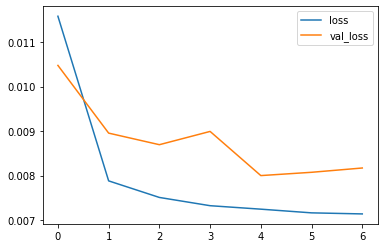

In [45]:
perdidas = pd.DataFrame(modelo.history.history)
perdidas.plot()

## Evaluate on Test Data

In [54]:
primera_tanda_eval = datos_entreno_escalados[-longitud:]

In [55]:
primera_tanda_eval

array([[0.1038961 , 0.        , 0.72231687, ..., 0.53550296, 0.15909546,
        0.15909546],
       [0.11688312, 0.        , 0.73424191, ..., 0.52662722, 0.40344207,
        0.40344207],
       [0.11688312, 0.        , 0.73424191, ..., 0.51775148, 0.20452271,
        0.20452271],
       ...,
       [0.18181818, 0.        , 0.70017036, ..., 0.50118343, 0.33340004,
        0.33340004],
       [0.09090909, 0.        , 0.70017036, ..., 0.51952663, 0.78747248,
        0.78747248],
       [0.1038961 , 0.        , 0.70017036, ..., 0.53846154, 0.77286372,
        0.77286372]])

In [56]:
primera_tanda_eval = primera_tanda_eval.reshape((1, longitud, 
                                                 datos_entreno_escalados.shape[1]))

In [57]:
modelo.predict(primera_tanda_eval)

array([[0.09670653, 0.03055497, 0.70059997, 0.38985354, 0.5431489 ,
        0.43969375, 0.39555717, 0.4329087 , 0.70479107, 0.38933966,
        0.31795803, 0.35020143, 0.6570898 , 0.00248323, 0.6113323 ,
        0.386271  , 0.5343202 , 0.3296315 , 0.54003346, 0.38268867,
        0.6019658 , 0.5160017 , 0.44331032, 0.19648728, 0.57005864,
        0.5508872 , 0.47855863, 0.4798274 ]], dtype=float32)

In [58]:
datos_prueba_escalados[0]

array([0.19480519, 0.        , 0.70017036, 0.3920434 , 0.53007217,
       0.41064526, 0.40616246, 0.41913319, 0.72714286, 0.4115245 ,
       0.30722892, 0.36445121, 0.66777778, 0.        , 0.61119082,
       0.39840637, 0.51618399, 0.32953105, 0.53703704, 0.34024896,
       0.6057377 , 0.52631579, 0.41881579, 0.2       , 0.55283333,
       0.53372781, 0.76305783, 0.76305783])

Toda la lógica anterior se pone dentro de una iteración para pronosticar hacia el futuro con el conjunto de prueba completo.

----

**NOTA:  ES IMPORTANTE PONER ATENCION A LO QUE ESTA SALIENDO Y EN QUE DIMENSIONES.  PUEDE AGREGAR SUS PROPIAS INSTRUCCIONES PRINT() PARA VER MEJOR LO QUE ESTA OCURRIENDO!!**

In [59]:
n_features = datos_entreno_escalados.shape[1]
predicciones_prueba = []

primera_tanda_eval = datos_entreno_escalados[-longitud:]
tanda_actual = primera_tanda_eval.reshape((1, longitud, n_features))

for i in range(len(prueba)):
    
    # obtener el pronóstica de un paso de tiempo en el futuro 
    #   ([0] es para obtener sólo el número en vez de la totalidad
    #    de [array])
    pred_actual = modelo.predict(tanda_actual)[0]
    
    # guardar la predicción
    predicciones_prueba.append(pred_actual) 
    
    # actualizar la tanda para que incluya la ultima predicción
    #     así como eliminar el primer valor
    tanda_actual = np.append(tanda_actual[:,1:,:],[[pred_actual]],
                             axis = 1)

In [60]:
predicciones_prueba

[array([0.09670653, 0.03055497, 0.70059997, 0.38985354, 0.5431489 ,
        0.43969375, 0.39555717, 0.4329087 , 0.70479107, 0.38933966,
        0.31795803, 0.35020143, 0.6570898 , 0.00248323, 0.6113323 ,
        0.386271  , 0.5343202 , 0.3296315 , 0.54003346, 0.38268867,
        0.6019658 , 0.5160017 , 0.44331032, 0.19648728, 0.57005864,
        0.5508872 , 0.47855863, 0.4798274 ], dtype=float32),
 array([0.08195858, 0.04246108, 0.6888292 , 0.3922737 , 0.5366563 ,
        0.4465896 , 0.37676013, 0.43749997, 0.69284534, 0.3796098 ,
        0.32852143, 0.33535933, 0.64111954, 0.01044499, 0.61049914,
        0.38099778, 0.5439672 , 0.34269986, 0.53616756, 0.40257794,
        0.5950257 , 0.5080994 , 0.4605583 , 0.17456073, 0.5301407 ,
        0.55844617, 0.47266412, 0.47936356], dtype=float32),
 array([0.07573123, 0.0474153 , 0.67836165, 0.39451998, 0.52694404,
        0.45386258, 0.36091146, 0.4435045 , 0.6852449 , 0.3746279 ,
        0.34014657, 0.32551086, 0.62549496, 0.02131077, 0.6091

In [61]:
datos_prueba_escalados

array([[0.19480519, 0.        , 0.70017036, ..., 0.53372781, 0.76305783,
        0.76305783],
       [0.37662338, 0.        , 0.70017036, ..., 0.52840237, 0.62337402,
        0.62337402],
       [0.12987013, 0.        , 0.70017036, ..., 0.52366864, 0.08785271,
        0.08785271],
       ...,
       [0.32467532, 0.33333333, 0.87052811, ..., 0.86804734, 0.58415049,
        0.58415049],
       [0.51948052, 0.33333333, 0.87052811, ..., 0.86568047, 0.12627577,
        0.12627577],
       [0.53246753, 0.33333333, 0.87052811, ..., 0.86390533, 0.68260957,
        0.68260957]])

## Transformaciones Inversas y comparar

In [62]:
predicciones_reales = escalador.inverse_transform(predicciones_prueba)

In [63]:
predicciones_reales

array([[ 94.4640296 ,   0.91664918,  24.50252181, ...,   7.90999414,
         23.92357473,  23.98697538],
       [ 83.10811006,   1.27383236,  24.43342731, ...,   8.03774025,
         23.62902597,  23.96379713],
       [ 78.31304923,   1.42245915,  24.37198291, ...,   8.16215819,
         23.48892591,  23.79584266],
       ...,
       [568.83646846, -13.92795235,  21.53104008, ...,  -4.36225449,
         24.07358258,  21.88126603],
       [568.84560168, -13.9281857 ,  21.53089155, ...,  -4.3625995 ,
         24.07313432,  21.88177535],
       [568.85624945, -13.92848611,  21.53078266, ...,  -4.36283924,
         24.07282605,  21.88224296]])

In [64]:
prueba

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.50,37.86,24.00,34.27,25.00,36.70,24.29,37.79,21.20,51.37,19.32,1.00,23.29,34.70,24.39,39.13,22.00,37.23,16.48,756.1,55.83,2.00,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.50,37.30,23.86,34.33,24.94,36.67,24.29,37.79,21.29,51.14,19.39,1.00,23.32,34.76,24.41,39.62,22.00,37.36,16.47,756.1,55.67,2.00,36.33,7.53,31.16,31.16
2016-05-25 18:30:00,120,0,24.50,36.96,23.73,34.33,24.85,36.50,24.29,37.79,21.32,50.73,19.43,1.00,23.36,34.94,24.50,40.34,22.03,37.39,16.45,756.1,55.50,2.00,34.50,7.45,4.40,4.40
2016-05-25 18:40:00,120,0,24.50,37.00,23.70,34.40,24.84,36.45,24.29,37.90,21.39,50.35,19.36,1.00,23.39,35.00,24.55,40.54,22.10,37.72,16.43,756.1,55.33,2.00,32.67,7.37,27.12,27.12
2016-05-25 18:50:00,120,0,24.49,37.07,23.68,34.52,24.84,36.49,24.28,37.93,21.39,50.35,19.25,1.66,23.39,35.05,24.54,40.59,22.10,37.81,16.42,756.1,55.17,2.00,30.83,7.28,10.27,10.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,23.20,52.40,24.80,1.00,24.50,44.50,24.70,50.07,23.20,46.79,22.73,755.2,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,23.23,52.33,24.20,1.00,24.56,44.41,24.70,49.79,23.20,46.79,22.60,755.2,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,23.23,52.27,23.63,1.00,24.54,44.40,24.70,49.66,23.20,46.79,22.47,755.2,56.33,3.67,25.33,13.27,29.20,29.20


In [65]:
predicciones_reales = pd.DataFrame(data = predicciones_reales,
                                   columns = prueba.columns)

In [66]:
predicciones_reales

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,94.464030,0.916649,24.502522,37.799450,24.163066,35.246901,24.924278,36.960633,24.133537,37.301046,21.271241,50.527410,19.031425,1.143506,23.290986,34.425862,24.496459,39.132378,22.016181,38.150517,16.387965,755.864839,57.691584,1.964873,39.203519,7.909994,23.923575,23.986975
1,83.108110,1.273832,24.433427,37.866368,24.082104,35.478808,24.790067,37.047499,24.049917,37.086600,21.341382,49.649797,18.600228,1.603616,23.285179,34.306740,24.553087,39.441706,21.995305,38.581915,16.218628,755.684666,59.002430,1.745607,36.808442,8.037740,23.629026,23.963797
2,78.313049,1.422459,24.371983,37.928478,23.960992,35.723398,24.676908,37.161105,23.996714,36.976799,21.418573,49.067457,18.178364,2.231550,23.275963,34.245267,24.609604,39.737956,21.992896,38.950911,16.002378,755.512448,60.259950,1.494395,34.480195,8.162158,23.488926,23.795843
3,74.289941,1.494640,24.308209,37.967966,23.802959,35.971331,24.577284,37.263619,23.953268,36.902824,21.485249,48.713411,17.727807,2.891281,23.255816,34.209873,24.657709,40.010092,21.992772,39.267899,15.756293,755.344691,61.457638,1.243365,32.561679,8.258772,23.368959,23.637937
4,70.551941,1.523273,24.244778,38.006186,23.625613,36.235305,24.490125,37.353546,23.916421,36.852557,21.546142,48.522863,17.279034,3.584793,23.232979,34.197350,24.699666,40.265875,21.994335,39.543448,15.504200,755.193441,62.657124,1.003303,31.067924,8.346992,23.268931,23.495610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,568.826693,-13.927777,21.531432,36.781138,22.954730,41.736998,20.514896,15.068783,28.090140,34.804976,19.680517,-57.415614,20.850658,-92.572562,33.799644,21.383229,31.130965,36.588443,29.485196,57.323348,-9.898168,775.767997,82.714818,20.806298,45.326912,-4.361193,24.074878,21.880194
284,568.829859,-13.927802,21.531224,36.781286,22.955461,41.735473,20.515336,15.069492,28.090304,34.804870,19.680815,-57.414211,20.852551,-92.578328,33.799254,21.382387,31.130761,36.587613,29.484807,57.322929,-9.897613,775.767315,82.710402,20.806634,45.328068,-4.361785,24.074172,21.880730
285,568.836468,-13.927952,21.531040,36.781312,22.956287,41.733779,20.515769,15.069904,28.090463,34.804568,19.681005,-57.413366,20.854332,-92.584239,33.798964,21.381579,31.130590,36.586710,29.484452,57.322272,-9.897258,775.766595,82.706895,20.807199,45.329280,-4.362254,24.073583,21.881266
286,568.845602,-13.928186,21.530892,36.781246,22.957156,41.732011,20.516176,15.070035,28.090622,34.804111,19.681099,-57.413055,20.855919,-92.589943,33.798778,21.380841,31.130459,36.585793,29.484144,57.321445,-9.897085,775.765896,82.704350,20.807946,45.330485,-4.362599,24.073134,21.881775


# FIN!

## EXTRA:
### Guardar el modelo

In [67]:
from tensorflow.keras.models import load_model

In [68]:
modelo.save("multivariada.h5")